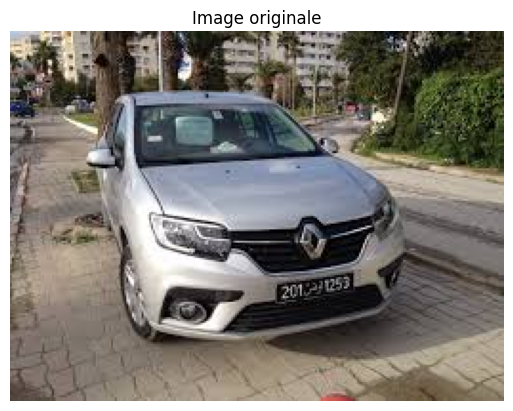


image 1/1 d:\Downloads\project\images.jpg: 480x640 1 license_plate, 159.2ms
Speed: 9.3ms preprocess, 159.2ms inference, 12.2ms postprocess per image at shape (1, 3, 480, 640)
✅ 1 plaque(s) détectée(s)


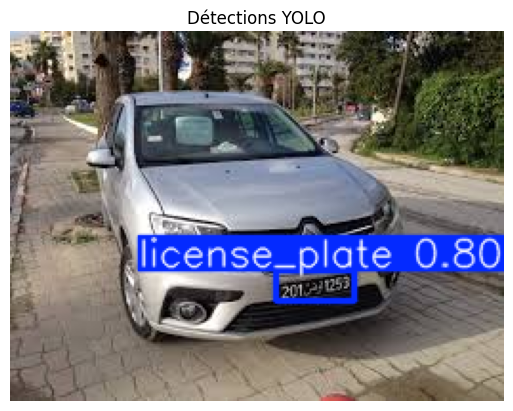

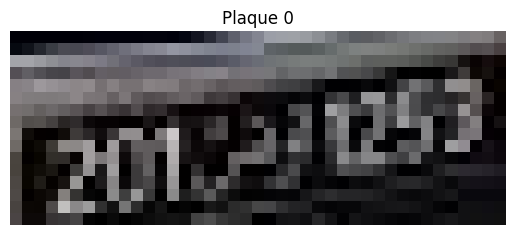

In [10]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os

# =========================
# Chargement du modèle entraîné
# =========================
model_path = "best1.pt"
if not os.path.exists(model_path):
    raise FileNotFoundError(f"❌ Le fichier {model_path} n'existe pas. Vérifie ton entraînement !")

model = YOLO(model_path)

# =========================
# Dossier et image à tester
# =========================
img_path = "images.jpg"
if not os.path.exists(img_path):
    raise FileNotFoundError(f"❌ L'image {img_path} n'existe pas !")

output_dir = "runs/detect/mp"
os.makedirs(output_dir, exist_ok=True)

# =========================
# Lecture de l'image
# =========================
img = cv2.imread(img_path)
if img is None:
    raise ValueError("❌ Impossible de charger l'image")

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.title("Image originale")
plt.axis("off")
plt.show()

# =========================
# Prédiction YOLO
# =========================
results = model.predict(
    source=img_path,
    imgsz=640,      # même taille que l'entraînement
    conf=0.25,      # seuil raisonnable
)

# =========================
# Vérification des détections
# =========================
if len(results[0].boxes) == 0:
    print("❌ Aucune plaque détectée")
else:
    print(f"✅ {len(results[0].boxes)} plaque(s) détectée(s)")

    # =========================
    # Affichage des bounding boxes
    # =========================
    annotated_img = results[0].plot()
    plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
    plt.title("Détections YOLO")
    plt.axis("off")
    plt.show()

    # =========================
    # Crop et sauvegarde
    # =========================
    for i, box in enumerate(results[0].boxes.xyxy.cpu().numpy()):
        x1, y1, x2, y2 = map(int, box)

        # Sécurité sur les bornes
        h, w = img.shape[:2]
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)

        crop = img[y1:y2, x1:x2]

        if crop.size == 0:
            continue

        crop_path = os.path.join(output_dir, f"plate_crop_{i}.png")
        cv2.imwrite(crop_path, crop)

        plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        plt.title(f"Plaque {i}")
        plt.axis("off")
        plt.show()


In [1]:
import pandas as pd
import random

def generate_mock_db(n=1000):
    data = []
    types = ["Privé", "Location", "Gouvernemental", "Régime Spécial"]
    assurances = ["Valide", "Expirée"]
    couleurs_vehicule = ["Noir", "Blanc", "Gris", "Bleu", "Rouge"]

    for i in range(n):
        type_v = random.choice(types)
        # Génération du format de plaque selon le type [cite: 20, 22, 23]
        if type_v == "Privé":
            plaque = f"{random.randint(10, 250)} تونس {random.randint(1000, 9999)}"
        elif type_v == "Location":
            plaque = f"{random.randint(10, 250)} تونس {random.randint(1000, 9999)} L"
        elif type_v == "Gouvernemental":
            plaque = f"{random.randint(1, 20):02d} {random.randint(100000, 999999)}"
        else: # RS
            plaque = f"RS {random.randint(100000, 999999)}"

        assurance = random.choice(assurances)
        couleur = random.choice(couleurs_vehicule)
        
        # Un véhicule est conforme s'il est enregistré et que son assurance est valide
        statut = "Conforme" if assurance == "Valide" else "Non conforme"

        data.append([plaque, type_v, couleur, assurance, statut])

    return pd.DataFrame(data, columns=["plaque", "type", "couleur_vehicule", "assurance", "statut"])

# Générer et sauvegarder
df = generate_mock_db(1000)
df.to_csv("database.csv", index=False, encoding='utf-8-sig')
print("Fichier database.csv de 1000 lignes généré avec succès !")

Fichier database.csv de 1000 lignes généré avec succès !


In [3]:
import json

def generate_knowledge_base():
    # Liste des règles extraites des documents officiels (ATTT, Code de la route)
    knowledge_data = [
        {
            "id": "RULE_001",
            "source": "ATTT / Format Ordinaire",
            "content": "Les plaques d'immatriculation ordinaires en Tunisie doivent afficher des chiffres blancs sur un fond noir. Le format obligatoire est : numéro, suivi de la mention 'تونس' en arabe, suivi d'un numéro.",
            "metadata": {"type": "format", "color": "black"}
        },
        {
            "id": "RULE_002",
            "source": "ATTT / Location",
            "content": "Pour les véhicules de location, le format visuel est identique aux plaques ordinaires (fond noir), mais avec l'ajout obligatoire d'un autocollant vert portant la lettre 'L'.",
            "metadata": {"type": "location", "sticker": "L"}
        },
        {
            "id": "RULE_003",
            "source": "Code de la Route / Art. 82",
            "content": "Les plaques à fond rouge avec des caractères blancs sont exclusivement réservées aux véhicules de l'État et des administrations publiques.",
            "metadata": {"type": "government", "color": "red"}
        },
        {
            "id": "RULE_004",
            "source": "ATTT / Format État",
            "content": "Le format des plaques gouvernementales est 'XX XXXXXX', où les deux premiers chiffres (XX) désignent le code du ministère concerné.",
            "metadata": {"type": "government", "format": "XX XXXXXX"}
        },
        {
            "id": "RULE_005",
            "source": "Normes de Conformité",
            "content": "Une plaque est jugée non conforme si elle utilise des tirets ou une translittération au lieu de la mention centrale 'تونس' en caractères arabes.",
            "metadata": {"issue": "text_format"}
        },
        {
            "id": "RULE_006",
            "source": "Régime Spécial",
            "content": "Les véhicules sous régime spécial ou temporaire utilisent des séries spécifiques comme 'RS' avec des caractères blancs sur fond noir.",
            "metadata": {"type": "special", "series": "RS"}
        }
    ]

    # Sauvegarde dans un fichier JSON pour l'indexation RAG
    with open('knowledge_base.json', 'w', encoding='utf-8') as f:
        json.dump(knowledge_data, f, ensure_ascii=False, indent=4)
    
    print("✅ Base de connaissances générée : knowledge_base.json")

if __name__ == "__main__":
    generate_knowledge_base()

✅ Base de connaissances générée : knowledge_base.json
